# Практикум по стохастическому анализу. Часть №1

Выполнил \
Пилюшенок Артур \
студент 415 группы ВМК МГУ

In [9]:
import numpy as np                              # matrix calculations
from matplotlib import pyplot as plt            # plotting
from scipy.stats import ecdf, norm, poisson     # empirical cumulative distribution function, normal distribution
from scipy.special import factorial             # for vectorized factorial computing

In [10]:
# plt.rcParams['figure.dpi'] = 300                # set default resolution for beatiful plots

In [11]:
# np.random.seed(415)                             # fixate seed for reproducability
# actually, we should use a different generator and pass it around, but we don't need that for project this small:
# rng = np.random.default_rng(415)

## Задание 1

### Условие
1. Реализовать генератор схемы Бернулли с заданной вероятностью успеха $p$. На
основе генератора схемы Бернулли построить датчик биномиального распределения.

2. Реализовать генератор геометрического распределения; проверить для данного
распределения свойство отсутствия памяти.

3. Промоделировать игру в орлянку: бесконечную последовательность независимых испытаний Бернулли 
с бросанием “правильной” (честной, $p=0.5$) монеты. Величина “выигрыша” $S_n$ определяется как сумма 
по $n$ испытаниям значений 1 и −1 в зависимости от выпавшей стороны монеты. Проиллюстрировать в виде
ломаной поведение нормированной суммы $Y(i)=\frac{S_i}{\sqrt{n}}$ как функцию от номера испытания $i$ 
для отдельно взятой траектории. Дать теоретическую оценку для значения $Y(n)$ при $n\to\infty$.

### Генераторы схемы Бернулли и биномиального распределения

Воспользуемся методом обращения функции распределения.

Мы будем использовать генератор многомерной выборки, отвечающей схеме Бернулли, реализованный при помощи метода $\texttt{numpy.random.rand}$. \
Это позволит нам генерировать несколько двумерных выборок одновременно.

In [12]:
def rand_bern(p, *args):
    '''
    Bernoulli's scheme generator
    returns tensor with given shapes
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if not isinstance(p, float):
        raise ValueError("Probability of success must be a float number.")
    if p > 1 or p < 0:
        raise ValueError("Probability of success must be in the range [0,1].")
    if not args:
        return int(np.random.rand() < p)
    return (np.random.rand(*args) < p).astype(int)

В качестве примера работы генератора схемы Бернулли изобразим гистограмму для выборки размера $N = 10^7$. \
Вероятность единицы должна быть близка к параметру $p$ генератора.

In [13]:
p = 0.54321
N = 10**7
sample_bern = rand_bern(p, N)

Параметр p=0.54321.
Вероятность единицы в выборке: 0.54334.


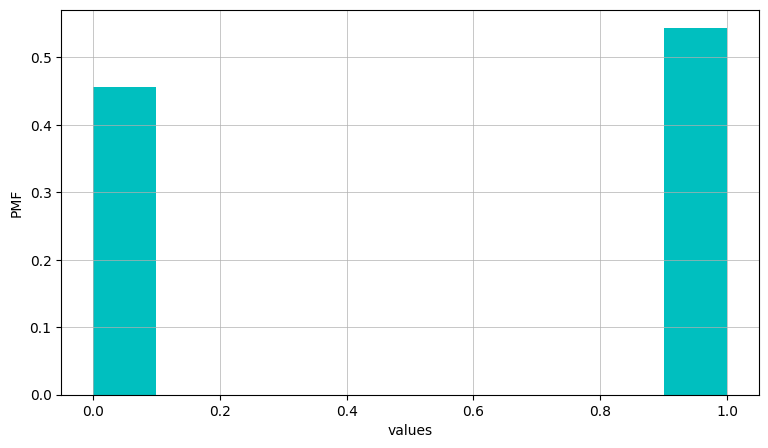

In [14]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

counts, bins = np.histogram(sample_bern)
ax.stairs(counts / N, bins, fill=True, color='c')
print('Параметр p={:1.5f}.\nВероятность единицы в выборке: {:1.5f}.'.format(p, counts[-1] / N))

plt.ylabel('PMF')
plt.xlabel('values')
plt.show()

Далее воспользуемся $\texttt{rand\_bern}$ для реализации генератора $\mathrm{Bin}(n,p)$.

Здесь можно сгенерировать одним запуском $n$ выборок схемы Бернулли, но при больших $n$ память легко может переполниться. \
Например, двумерная выборка размерности $100$ на $100$ при $n=10^7$ переполняет свободную память компьютера, хотя и состоит всего из $10^5$ значений.

Чтобы избежать переполнения памяти при больших $n$, можно запускать $\texttt{rand\_bern}$ в цикле.

In [15]:
def rand_bin(n, p, *args):
    '''
    Binomial distribution generator
    returns tensor with given shapes
    n - count of trials, is positive integer number
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_bern
    '''
    if not isinstance(n, int) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return rand_bern(p, n, *args).sum(axis=0)

Отметим, что генерация одним запуском в разы эффективнее генерации в цикле.
<!-- Приведем листинг эффективной по времени генерации, но приводящей к переполнению.
```python
def rand_bin(n, p, *args):
    if not isinstance(n, int) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return rand_bern(p, n, *args).sum(axis=0)
``` -->
Данной реализацией можно пользоваться при произведении $n$ на все результирующие размерности меньшем $10^8$ (или меньшем количества свободных байт в памяти компьютера). Для генерации выборок большого размера будем последовательно вызывать генератор.

Продемонстрируем работу датчика биномиального распределения: проверим выполнение ЦПТ.

In [16]:
n = 66
p = 0.54321
N = 10**6

sample_bin = rand_bin(n, p, N)

mu = n*p
sigma = np.sqrt(n*p*(1-p))
print('Teoretical mu={:1.4}, sigma={:1.4}'.format(mu, sigma))
print('Numerical mu={:1.4}, sigma={:1.4}'.format(sample_bin.mean(), sample_bin.std()))

Teoretical mu=35.85, sigma=4.047
Numerical mu=35.85, sigma=4.048


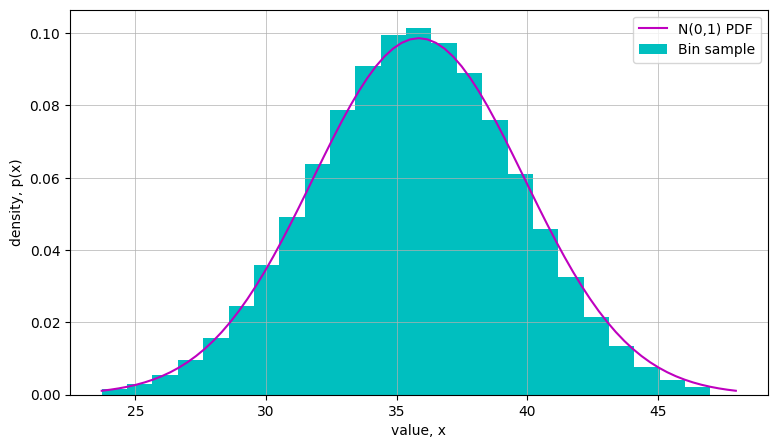

In [17]:
n_bins = 25
grid = np.linspace(mu - 3*sigma, mu + 3*sigma, n_bins*3)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_bin, bins=n_bins, range=(mu - 3*sigma, mu + 3*sigma), color='c', density=True)
ax.plot(grid, norm.pdf(grid, loc=mu, scale=sigma), color='m')

plt.ylabel('density, p(x)')
plt.xlabel('value, x')
plt.legend(['N(0,1) PDF', 'Bin sample'])
plt.show()

### Генератор геометрического распределения


Всюду далее считаем, что геометрическое распределение - это распределение числа неуспехов до первого успеха 
в схеме Бернулли с неограниченным числом испытаний.

Обозначим
$$
\xi \sim \operatorname{Geom}(p),\quad \nu \sim \operatorname{U}[0,1].\\
\mathbb{P}(\xi = n) = p(1-p)^n,\quad \sum_{k=0}^{n} p(1-p)^k = 1 - (1-p)^{n+1} = s_{n+1}.
$$
Пользуясь генератором равномерного распределения, реализуем генератор геометрического распределения, исходя из следующих соображений:
$$
\mathbb{P}(\xi = n) = \mathbb{P}(s_{n}<\nu\leqslant s_{n+1}) = \mathbb{P}((1-p)^{n+1} \leqslant 1-\nu < (1-p)^{n}).
$$
$$
\Longrightarrow~ \boxed{\mathbb{P}(\xi = n) = \mathbb{P}\left( n < \dfrac{\ln{(1-\nu)}}{\ln(1-p)} \leqslant n+1  \right).}
$$
Отметим, что $(1-\nu) \sim \operatorname{U}[0,1]$.

Таким образом, будем моделировать случайную величину
$$
\eta = \bigg\lfloor \dfrac{\ln\nu}{\ln(1-p)} \bigg\rfloor.
$$

Можно доказать, что $\frac{\ln\nu}{\ln(1-p)}\sim\mathrm{Exp}(-\ln\frac{1}{1-p})$:
$$
\mathbb{P}\left(\frac{\ln\nu}{\ln(1-p)}<x\right) = \mathbb{P}(\nu < e^{\ln(1-p)x}) = 1 - e^{\ln(1-p)x}.
$$

In [18]:
def rand_geom(p, *args):
    '''
    Geometrical distribution generator
    returns tensor with given shapes
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if not isinstance(p, float):
        raise ValueError("Probability of success must be a float number.")
    if p > 1 or p < 0:
        raise ValueError("Probability of success must be in range [0,1].")
    return np.floor(np.log(np.random.rand(*args)) / np.log(1-p)).astype(int)

Покажем, что данное распределение обладает свойством отсутствия памяти:
$$
\mathbb{P}(\xi > m+n ~\vert~ \xi \geqslant m) = \mathbb{P}(\xi > n),~ \forall m,n \in \{0,1,2\dots\}
$$

Для этого построим две гистограммы для двух выборок (отвечающих левой и правой частям соответственно). \
Сдвинутые графики должны совпасть.

In [19]:
p = 0.2
N = 10**7
m = 7

sample_geom_1 = rand_geom(p, N)
sample_geom_2 = rand_geom(p, N)
sample_geom_2 = sample_geom_2[sample_geom_2 >= m]
sample_geom_2.shape

(2095849,)

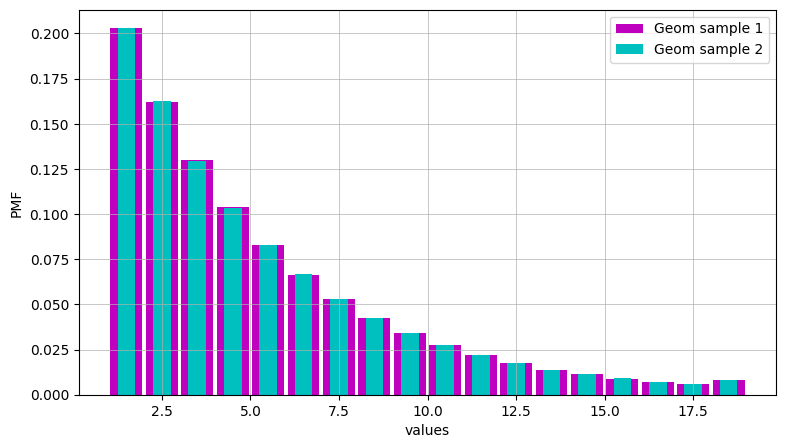

In [20]:
n_bins = 30
bins = np.arange(1, np.ceil(n_bins * 2/3))

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_geom_1, bins, density=True, rwidth=0.9, color='m')
ax.hist(sample_geom_2 - m, bins, density=True, rwidth=0.5, color='c')

plt.ylabel('PMF')
plt.xlabel('values')
plt.legend(['Geom sample 1', 'Geom sample 2'])
plt.show()

### Игра в орлянку

Рассмотрим
$$
S_n = \sum^{n}_{i=1} \eta_i,\quad \eta_i = 2\xi_i-1,\quad \xi_i \sim \operatorname{Be}(p) \text{ --- i.i.d.r.v.}\\
Y_n = \dfrac{S_n}{\sqrt{n}}.
$$

Зафиксируем $p=1/2$. В таком случае
$$
\mathbb{E}\nu_i \equiv \mu = 2p-1 = 0.\\
\mathbb{D}\nu_i \equiv \sigma^2 = 4p(1-p) = 1.
$$

Воспользуемся ЦПТ.
$$
\mathbb{P}\left( \dfrac{S_n - n\mu}{\sigma\sqrt{n}} < x \right) \to \Phi(x)=\dfrac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-y^2/2}dy,~n\to\infty.
$$

Заметим, что нормированная случайная величина внутри функции распределения в левой части выражения совпадает с $Y_n$. \
Также отметим, что третий абсолютный момент $\mathbb{E}|\eta_i|^3=1$, ведь $|\eta_i|\equiv1$. \
В таком случае можем воспользоваться неравенством Берри-Эссеена, где $c_0\in(0.4,0.5)$.
$$
\sup_{x\in\mathbb{R}}\left| \mathbb{P}\left( \dfrac{S_n}{\sqrt{n}} < x \right) - \Phi(x) \right| < \dfrac{c_0}{n^{3/2}}.
$$

Получили оценку скорости сходимости в ЦПТ. \
Нас также интересует оценка значений $Y_n(\omega)$.

Уже показали, что
$$
Y_n \stackrel{d}{\to} \xi\sim\mathrm{N}(0,1).
$$
Следовательно, по мере увеличения числа элементов $n$ нормированная сумма $Y(n)$ будет распределена нормально.

Также продемонстрируем поведение траектории $Y_i = \frac{S_i}{\sqrt{n}},~ i=\overline{0,n}$.

In [21]:
def gen_orlyanka_trajectory(p, n):
    '''
    Orlyanka game trajectory generator
    returns trajectory of normalized summ Y_n in orlyanka game
    n - count of trials, is positive integer number
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_bern
    '''
    if not isinstance(n, int) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return np.append(0, (2 * rand_bern(p, n) - 1).cumsum() / np.sqrt(n))

def gen_orlyanka_value(p, n, *args):
    '''
    Orlyanka game generator
    returns tensor with given shapes
    n - count of trials, is positive integer number
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_bern
    '''
    if not isinstance(n, int) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return (2 * rand_bern(p, n, *args) - 1).sum(axis=0) / np.sqrt(n)

In [22]:
p = 0.5
n = 1000
N = 10000

In [23]:
y = gen_orlyanka_trajectory(p, n)

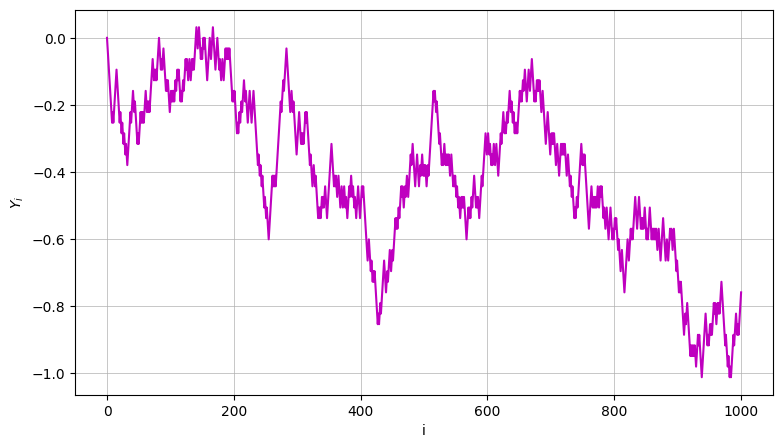

In [24]:
x = np.arange(0, n+1)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(x, y, color='m')

plt.xlabel('i')
plt.ylabel('$Y_i$')
plt.show()

In [25]:
sample_orlyanka = gen_orlyanka_value(p, n, N)

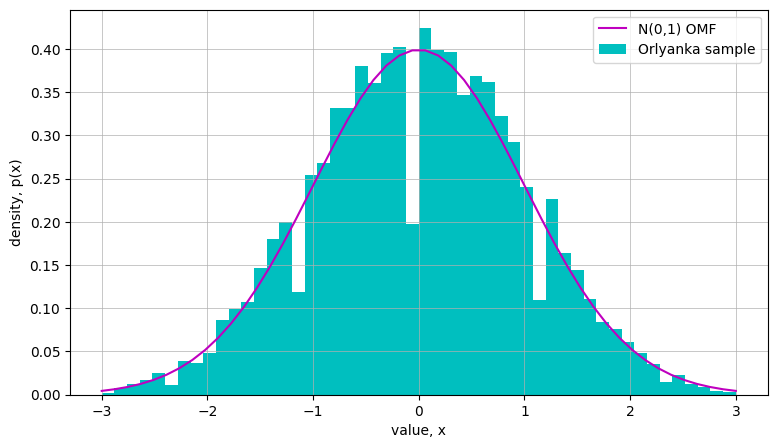

In [26]:
n_bins = 50
grid = np.linspace(-3, 3)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_orlyanka, bins=n_bins, range=(-3,3), density=True, color='c')
ax.plot(grid, norm.pdf(grid, loc=0.0, scale=1.0), color='m')

plt.xlabel('value, x')
plt.ylabel('density, p(x)')
plt.legend(['N(0,1) OMF', 'Orlyanka sample'])
plt.show()

## Задание 2

### Условие

1. Построить датчик сингулярного распределения, имеющий в качестве функции распределения канторову лестницу. 
С помощью критерия Колмогорова убедиться в корректности работы датчика.

2.  Для канторовых случайных величин с помощью критерия Смирнова проверить
свойство симметричности относительно $\frac{1}{2}$ ($X$ и $1 − X$ распределены одинаково)
и свойство самоподобия относительно деления на $3$ (условное распределение $Y$
при условии $Y ∈ [0, 1/3]$ совпадает с распределением $\frac{Y}{3}$).

3. Рассчитать значения математического ожидания и дисперсии для данного распределения. Сравнить теоретические значения с эмпирическими (для различных объемов выборок), проиллюстрировать сходимость эмпирических значений
к теоретическим.

### Генератор канторового распределения

Канторовская лестница задаётся на множестве Кантора (которое имеет нулевую меру Лебега) отрезка $[0,1]$, доопределяется по непрерывности в оставшихся точках. Канторовское распределение имеет функцию распределения, являющейся канторовской лестницей.

Есть два способа моделирования такого распределения:
1. По заданному $x\in[0,1]$. Канторовское множество состоит из тех точек, у которых нет единицы в троичной записи. Переведем $x$ в троичную запись, а затем отбросим все цифры после первой (самой левой) единицы.
2. По заданному размеру выборки $N$. Будем $N$ раз моделировать $n_{\operatorname{bits}}$ испытаний схемы Бернулли с $p=\frac{1}{2}$. Все единицы заменим на двойки, и получим троичную запись числа, в которой отсутствуют единицы.

Значением функции распределения $F(x)$ будет являться двоичное представление числа $x$. Его можно получить, заменив все двойки в троичной записи даного числа на единицы.

Число испытаний схемы Бернулли $n=n_{\operatorname{bits}}$ можно задавать с учётом заданной погрешности $\varepsilon$. В худшем случае отбрасываются двойки в троичной записи числа.
$$
\sum_{k=n+1}^{\infty} \dfrac{2^{k}}{3^{k}} = \dfrac{(\frac{2}{3})^{n+1}}{1 - \frac{2}{3}} < \varepsilon.
\quad\Rightarrow\quad
n + 1 < \log_{\frac{2}{3}}3\varepsilon.
$$

Будем генерировать канторовское распределение по заданному размеру выборки $N$ и точности $\varepsilon$.

In [31]:
def rand_Cantor(N, eps):
    '''
    Cantor's distribution with use of Bernoulli's scheme
    returns (x, y) where x,y \in [0,1], y corresponds to cumulative distribution function (CDF)
    N - count of points, is positive integer number
    eps - precision, is positive float number
    additional error handling in rand_bern
    '''
    if not isinstance(N, np.int64) or not N > 0:
        raise ValueError("Count of points must be a positive integer.")
    if not eps > 0:
        raise ValueError("Presicion must be positive.")
    p = 0.5
    n_bits = np.floor(np.log(3*eps)/np.log(2/3) - 1).astype(int)
    sample = np.empty(N)
    cdf = np.empty(N)
    for i in range(N):
        # get binary representation of float number after point
        X = rand_bern(p, n_bits)
        curr_point = 0
        curr_value = 0
        for j in range(1, n_bits+1):
            # change representation
            curr_point += 2 * X[j-1] / 3**j       # from 3 to 10
            curr_value += X[j-1] / 2**j           # from 2 to 10
        sample[i] = curr_point
        cdf[i] = curr_value
    return np.sort(sample), np.sort(cdf)

In [27]:
N = 10**5
eps = 1e-12
n_bits = np.floor(np.log(3*eps)/np.log(2/3) - 1).astype(int)
print(n_bits)

sample_Cantor, cdf_Cantor = rand_Cantor(N, eps)
ecdf_Cantor = ecdf(sample_Cantor)

64


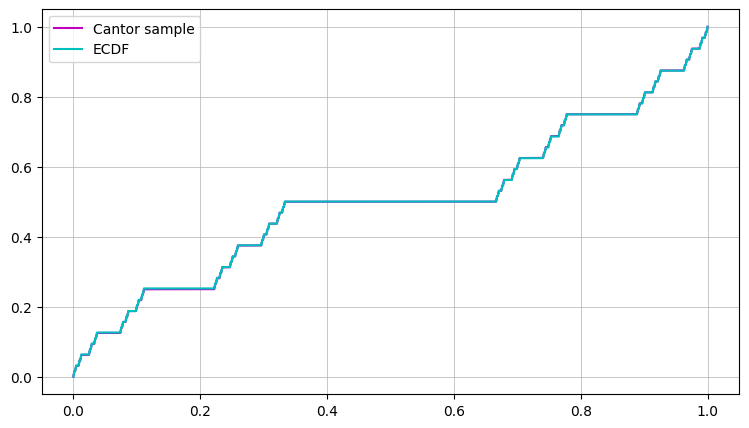

In [28]:
M = N // 2
grid = np.linspace(0, 1, M+1, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(sample_Cantor, cdf_Cantor, color='m', label='Cantor sample')
plt.plot(grid, ecdf_Cantor.cdf.evaluate(grid), color='c', label='ECDF')

plt.legend()
plt.show()

__Теорема__ (Колмогорова) Пусть $X_1,X_2,\dots,X_n$ — н.о.р.с.в. с функцией распределения $F(x)$. \
Пусть $F_n(x) = \frac{1}{n}\sum_{i=1}^n \mathbb{I}\{X_{(i)}<x\}$ — эмпирическая функция распределения (ECDF). \
Тогда 
$$
\lim_{n\to\infty} \mathbb{P}({\sqrt{n}D_n < x}) = F_K(x),
$$
где $D_n=\sup\limits_x|F_n(x)-F(x)|$ — статистика Колмогорова и $F_K(\cdot)$ — функция распределения Колмогорова, которую можно выразить по формуле
$$
F_K(x) = 1 + 2 \sum_{k=1}^{+\infty}(-1)^k e^{-2k^2x^2}.
$$

Проверяем гипотезу
$$
H_0:~F(\cdot)=F_C(\cdot),
$$
где $F_C(\cdot)$ — канторово распределение.

Критерии Колмогорова и Смирнова имеют правостороннюю критическую область.

По критерию Колмогорова решение принимается на основе двух векторов:
1. Вектора значений выборки.
2. Вектора значений функции распределения в этих точках выборки.

Функция $\texttt{rand\_Cantor}$ возвращает выборку из чисел отрезка $[0,1]$, в троичной записи которых отсутствует единица. \
Мы можем провести тест по выборкам такого типа.

In [29]:
def dist_Kolmogorov(x):
    '''
    Value of Kolmogorov distribution
    returns approximation of distribution value
    '''
    N = 300000
    res = [-2 * k * k * x * x for k in range(1,N+1)]
    res = np.exp(res)
    res = [(-1) ** k * res[k-1] for k in range(1,N+1)]
    return 1 + 2 * np.sum(res)

def stat_Kolmogorov(F_ecdf, F_cdf):
    '''
    Value of Kolmogorov's statistic
    F_ecdf and F_cdf are vectors, must be of same length
    '''
    if not len(F_ecdf) == len(F_cdf):
        raise ValueError('Given vectors must be of same length.')
    return np.max(np.abs(F_ecdf - F_cdf))

def test_Kolmogorov(sample, cdf_at_sample):
    '''
    Kolmogorov's test
    returns p-value 
    sample and cdf_at_sample are vectors, must be of same length
    '''
    if not len(sample) == len(cdf_at_sample):
        raise ValueError('Given vectors must be of same length.')
    n = len(sample)
    F_ecdf = ecdf(sample).cdf.evaluate(sample)
    stat = stat_Kolmogorov(F_ecdf, cdf_at_sample)
    return 1 - dist_Kolmogorov(np.sqrt(n) * stat)

In [32]:
Ns = np.arange(1000, 1010 + 1)
eps = 1e-12
alpha = 0.05
results = np.zeros(Ns.shape)
for i in range(len(Ns)):
    sample_Cantor, cdf_Cantor = rand_Cantor(Ns[i], eps)
    p_value = test_Kolmogorov(sample_Cantor, cdf_Cantor)
    results[i] = p_value
print(results)

[0.79186114 0.43844933 0.8328655  0.77373555 0.94783255 0.31264458
 0.36395442 0.65072528 0.81777733 0.11518319 0.44500517]


### Свойства канторового распределения

### Численные характеристики канторового распределения

## Задание 3

### Условие

1. Построить датчик экспоненциального распределения. Проверить для данного
распределения свойство остутствия памяти.

2. Пусть $X_1,X_2,\dots,X_n$ --- независимые экспоненциально распределенные случайные величины с параметрами
$\lambda_1,\lambda_2,\dots,\lambda_n$. Найти распределение случайной величины $Y=\min\{X_1,X_2,\dots,X_n\}$.

3. На основе датчика экспоненциального распределения построить датчик пуассоновского распределения.

4. Построить датчик пуассоновского распределения как предел биномиального распределения. Убедиться в корректности
построенного датчика при помощи критерия $\chi^2$ Пирсона.

5. Построить датчик стандартного нормального распределения методом моделирования случайных величин парами с переходом в полярные координаты 
(преобразование Бокса-Мюллера). Проверить при помощи t-критерия Стьюдента равенство математических ожиданий, а при помощи критерия Фишера — 
равенство дисперсий.

### Генератор экспоненциального распределения

Экспоненциальное распределение - абсолютно непрерывное распределение с плотностью $\lambda e^{-\lambda x},~\lambda>0$.

Рассмотрим $\lambda > 0$. Будем генерировать случайную величину
$$
\xi = -\frac{1}{\lambda}\ln\nu,\quad \nu\sim\mathrm{U}[0,1].
$$
Она имеет экспоненциальное распределение $\mathrm{Exp}(\lambda)$, ведь
$$
\mathbb{P}(\xi < x) = \mathbb{P}(-\frac{1}{\lambda}\ln\nu < x) = \mathbb{P}(\nu > e^{-\lambda x}) = 1 - e^{-\lambda x}.
$$

In [31]:
def rand_exponential(l, *args):
    if not l > 0:
        raise ValueError('Parameter of exponential distribution must be a positive float number.')
    return -np.log(np.random.rand(*args)) / l

In [32]:
L = 0.5
N = 10**5
sample_exponential = rand_exponential(L, N)

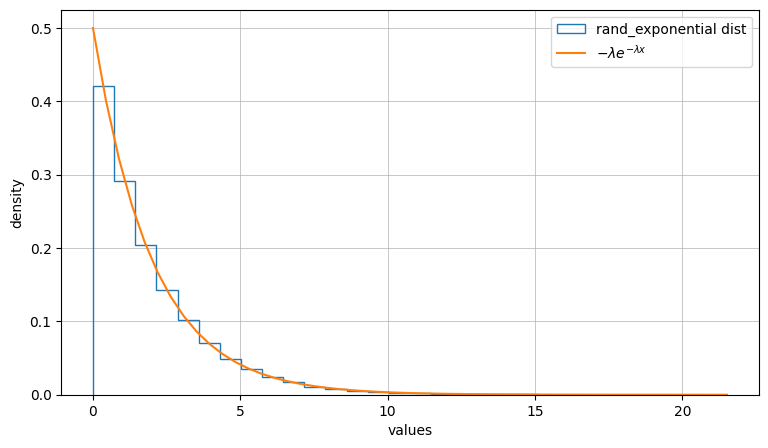

In [33]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

x = np.linspace(0, sample_exponential.max())
ax.hist(sample_exponential, bins=30, density=True, histtype='step', label='rand_exponential dist')
ax.plot(x, L * np.exp(-L * x), label='$-\lambda e^{-\lambda x}$')

plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

Проверим свойство отсутствия памяти аналогично геометрическому распределению.

In [34]:
L = 0.5
N = 10**6
m = 5
sample_expo_1 = rand_exponential(L, N)
sample_expo_2 = rand_exponential(L, N)
sample_expo_2 = sample_expo_2[sample_expo_2 > m] - m

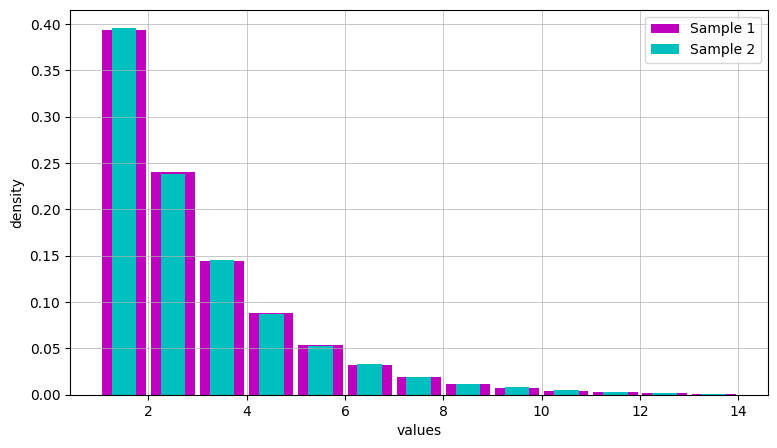

In [35]:
n_bins = 15
bins = np.arange(1, n_bins)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_expo_1, bins, density=True, range=(0,M), rwidth=0.9, color='m', label='Sample 1')
ax.hist(sample_expo_2, bins, density=True, range=(0,M), rwidth=0.5, color='c', label='Sample 2')

plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

### Распределение $Y=\min\{X_1,X_2,\dots,X_n\}$.

Имеем
$$
X_k \sim \mathrm{Exp}(\lambda_k),~ k\in\overline{0,n} \text{ --- i.i.d.r.v.}
$$

Генератор строим из следующих соображений.
$$
\begin{aligned}
\mathbb{P}(Y < x) &= 1 - \mathbb{P}(\min\{X_1,X_2,\dots,X_n\} \geqslant x) = \\
&= 1 - \mathbb{P}(X_1 \geqslant x, X_2 \geqslant x, \dots, X_n \geqslant x) = \{\text{независимость}\} = \\
&= 1 - \prod_{k=1}^{n}\mathbb{P}(X_k \geqslant x) = 1 - \prod_{k=1}^{n}(1 - \mathbb{P}(X_k < x)) = \\
&= 1 - \prod_{k=1}^{n}e^{-\lambda_kx} = 1 - e^{-(\lambda_1+\lambda_2+\dots+\lambda_n)x}.
\end{aligned}
$$
Получили, что $Y\sim\mathrm{Exp}(\sum_{k=1}^n\lambda_k)$.

Докажем полученное эмпирически. \
Для этого построим эмпирические функции распределения $Y$ по явной формуле и $Y$ как экспоненциальное распределение.

In [36]:
def gen_minimum_expo(lambdas, *args):
    n = len(lambdas)
    X = np.empty([n, *args])
    for k in range(n):
        X[k] = rand_exponential(lambdas[k], *args)
    return np.min(X, axis=0)

In [37]:
N = 1000
n = 100
lambdas = 7 * np.random.rand(n)

Y_sample_1 = gen_minimum_expo(lambdas, N)
Y_sample_2 = rand_exponential(lambdas.sum(), N)

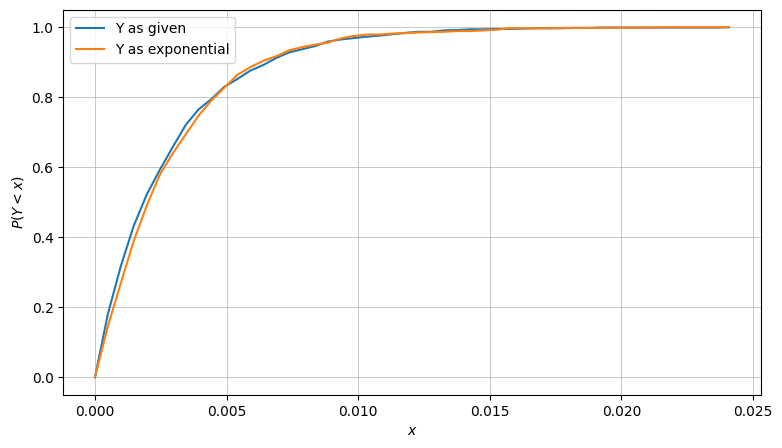

In [38]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

grid = np.linspace(0, max(Y_sample_1.max(), Y_sample_2.max()))
ecdf_expo_1 = ecdf(Y_sample_1).cdf.evaluate(grid)
ecdf_expo_2 = ecdf(Y_sample_2).cdf.evaluate(grid)
ax.plot(grid, ecdf_expo_1, label='Y as given')
ax.plot(grid, ecdf_expo_2, label='Y as exponential')

plt.ylabel('$P(Y < x)$')
plt.xlabel('$x$')
plt.legend()
plt.show()

### Генератор пуассоновского распределения (через г-р экспоненциального р-я)

Пуассоновская случайная величина $X$ с параметром $\lambda > 0$ принимает значения $k\in\{0,1,2,\dots\}\equiv\mathbb{N}_0$, является дискретной:
$$
\mathbb{P}(X = k) = e^{-\lambda}\dfrac{1}{k!}\lambda^k.
$$
Причём $\mathbb{E}X=\mathbb{D}X=\lambda$.

Воспользуемся следующей теоремой.

__Теорема__. Пусть $X_1,X_2,\dots,X_n$ - н.о.р.с.в., $X_i\sim\mathrm{Exp}(\lambda),\lambda>0$. \
Положим $Y$ - наименьшее неотрицательное целое число такое, что
$$
\sum_{k=1}^{Y+1}X_i > 1.
$$
Тогда $Y\sim\mathrm{Pois}(\lambda)$.

Доказательство можно найти в [[1](https://www.cs.fsu.edu/~mascagni/Devroye.pdf)], с.501 (ошибка в формулировке теоремы)

In [56]:
def rand_poisson_expo(l):
    Y = 0
    summ = 0
    while True:
        summ += rand_exponential(l)
        if summ > 1:
            return Y
        else:
            Y += 1

def rand_poisson_expo_vec(l, *args):
    if not args:
        return rand_poisson_expo(l)
    else:
        Y = np.zeros(*args)
        summ = np.zeros(*args)
    while True:
        X = rand_exponential(l, *args)
        summ = summ + X
        Y[summ < 1] = Y[summ < 1] + 1
        if not np.any(Y[summ < 1]):
            return Y

def rand_poisson_expo_vec_test(l, N):
    res = np.zeros(N)
    for i in range(N):
        res[i] = rand_poisson_expo(l)
    return res

In [40]:
N = 10**5
L = 10

In [57]:
sample_poisson = rand_poisson_expo_vec(L, N)
print(sample_poisson.mean(), sample_poisson.var())

10.00977 10.0311945471


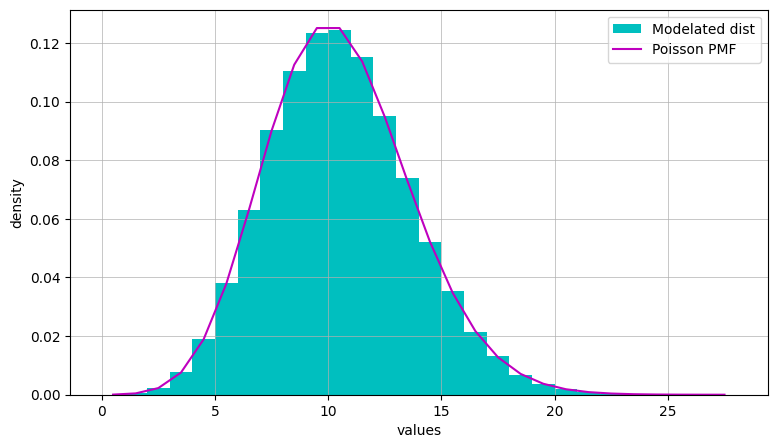

In [59]:
n_bins = np.unique(sample_poisson).shape[0]

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_poisson, bins=n_bins, density=True, label='Modelated dist', color='c')
grid = np.arange(0, n_bins)
ax.plot(grid+0.5, poisson.pmf(grid, mu=L), color='m', label='Poisson PMF')

plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

### Генератор пуассоновского распределения (через г-р биномиального р-я)

Воспользуемся Теоремой Пуассона.

__Теорема__ (Пуассон). Пусть есть последовательность биномиально распределенных случайных величин $X_n\sim\mathrm{Bin}(n, p_n)$ такая, что
1. $n\to\infty$.
2. $np_n\to\lambda,~n\to\infty$.

Тогда $\lim\limits_{n\to\infty}\mathbb{P}(X_n = m) = \dfrac{\lambda^m}{m!}e^{-\lambda}$.


__Доказательство__.

In [43]:
# def rand_poisson_bin(l, *args):
#     n_start = 100
#     n_end = 1000
#     for n in range(n_start, n_end+1):
#         p_n = l / n
#         X_n = rand_bin(p, *args)

def rand_poisson_bin(l, *args):
    n = 10**4
    p_n = l / n
    return rand_bin(n, p_n, *args)

In [44]:
sample_poisson_bin = rand_poisson_bin(L, 100)
sample_poisson_bin.mean(), sample_poisson_bin.var()

(9.82, 10.5476)

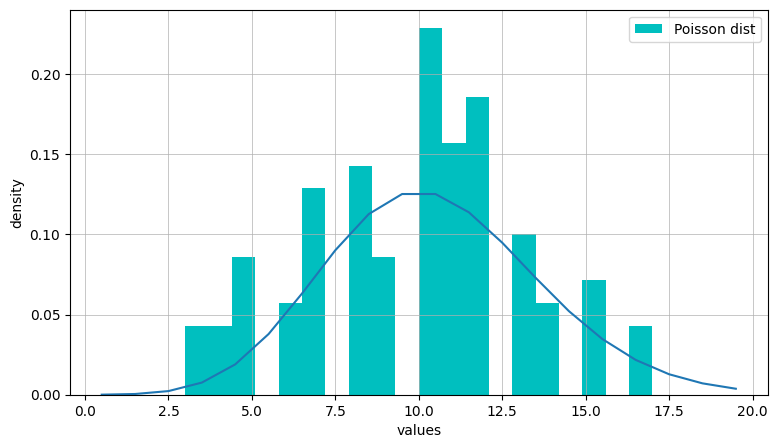

In [45]:
n_bins = 20
grid = np.arange(0, n_bins)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_poisson_bin, bins=n_bins, density=True, label='Poisson dist', color='c')
# ax.stairs(poisson.pmf(bins, mu=L))
ax.plot(grid+0.5, poisson.pmf(grid, mu=L))
# ax.stairs(true_probs)
# ax.hist(counts, bins, weights=true_probs, rwidth=0.5, color='r')

plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

## Задание 4

### Условие

1. Построить датчик распределения Коши.

2. На основе датчика распределения Коши с помощью метода фон Неймана построить датчик стандартного нормального распределения. При помощи 
графика normal probability plot убедиться в корректности построенного датчика и обосновать наблюдаемую линейную зависимость.

3. Сравнить скорость моделирования стандартного нормального распределения в задании 3 и в задании 4.

## Задание 5

### Условие

1. Пусть $X\sim \mathcal{N}(\mu,\sigma^2)$. Убедиться эмпирически в справедливости теоремы о законе больших чисел (ЗБЧ) и центральной предельной теоремы (ЦПТ): исследовать поведение суммы $S_n = \sum\limits_{i=1}^n X_i$ и эмпирического распределения величины
$$
\sqrt{n}\dfrac{S_n}{n} - a.
$$

2. Считая $\mu$, $\sigma$ неизвестными, построить доверительные интервалы для среднего и дисперсии по имеющейся выборке.

3. Пусть $X_i \sim K(a,b)$ --- имеет распределение Коши с параметрами сдвига $a$ и масштаба $b$. Изучить эмпирически как ведут себя суммы $\frac{S_n}{n}$, объяснить результат и найти закон распределения данных сумм.

## Задание 6

### Условие

1. Вычислить следующий интеграл:
$$
\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\cdots\int_{-\infty}^{\infty}\dfrac{e^{-(x_1^2+x_2^2+\dots+x_{10}^2 + \frac{1}{2^7\cdot x_1^2\cdots x_{10}^2})}}{x_1^2\cdot\dots\cdot x_{10}^2}dx_1dx_2\dots dx_{10}
$$

- Методом Монте-Карло
- Методом квадратур, сводя задачу к вычислению собственного интеграла Римана.

2. Оценить точность вычислений для каждого из двух случаев.

In [13]:
import numpy as np

# Количество случайных точек для метода Монте-Карло
num_samples = 10**6

# Генерация случайных точек для x1, x2, ..., x10 из нормального распределения
# Используем среднее 0 и стандартное отклонение 1/2 для генерации точек на всей числовой прямой
x_samples = np.random.normal(0, 0.5, (num_samples, 10))

# Вычисление подынтегральной функции для каждой случайной точки
def integrand(x):
    # x имеет размерность (num_samples, 10)
    square_sum = np.sum(x**2, axis=1)  # сумма квадратов x1^2 + x2^2 + ... + x10^2
    product_square_inv = np.prod(1 / x**2, axis=1)  # произведение 1 / x1^2 * 1 / x2^2 * ... * 1 / x10^2
    exponent = -(product_square_inv / 2**7)
    my_const = (np.pi) ** 5         # для плотности стандартного нормального распределения
    return my_const * np.exp(exponent) * product_square_inv

# Вычисляем среднее значение подынтегральной функции на выборке
integral_values = integrand(x_samples)
integral_estimate = integral_values.mean()

print("Приблизительное значение интеграла методом Монте-Карло:", integral_estimate)

Приблизительное значение интеграла методом Монте-Карло: 0.6351810185965822


In [5]:
import numpy as np
from scipy.integrate import quad
from scipy.special import gamma

# Угловой объем в 10-мерном пространстве
Omega_10 = 2 * np.pi**5 / gamma(5)

# Подынтегральная функция в сферических координатах
def integrand(r):
    exponent = - (r**2 + 1 / (2**7 * r**20))
    return np.exp(exponent) / r**2

# Численное интегрирование от 0 до бесконечности
result, error = quad(integrand, 0, np.inf)

# Умножаем на угловой объем
final_result = Omega_10 * result

print("Значение интеграла:", final_result)
print("Погрешность:", error)

Значение интеграла: 5.070681860123925
Погрешность: 1.0048983455155871e-09


## Список литературы

1. [L. Devroye (1986), Non-uniform random variate generation, Springer-Verlag, New York.](https://www.cs.fsu.edu/~mascagni/Devroye.pdf)